## Tunable Compression Autoencoder 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

import tensorflow_datasets as tfds
from tensorflow import keras 
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [2]:
# WANDB CONFIG

# start run, tracking hyperparameters
wandb.init(
    #set project
    project = "prelim",

    config = {
        "epochs": 3,
        "batch_size": 64,
        "latent_dim": 16,
        "num_encoding_layers": 3,
        "num_decoding_layers": 3,
        "enc_num_filters_1": 128,
        "enc_num_filters_2": 64,
        "enc_num_filters_3": 32,
        "dec_num_filters_1": 32,
        "dec_num_filters_2": 64,
        "dec_num_filters_3": 128,
        "metrics": "accuracy"
    }

)

config = wandb.config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: agoh (cuzime). Use `wandb login --relogin` to force relogin


## MNIST Dataset

In [3]:
# Prepare the dataset. We use both the training & test MNIST digits.

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print(np.shape(all_digits))
print(np.shape(x_train))
print(np.shape(x_test))

batch_size = config.batch_size

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size = 1024).batch(batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size = 1024).batch(batch_size)

(70000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Data Augmentation

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 13,
    zoom_range = 0.1, 
    shear_range = 10, 
    width_shift_range = 0.03,
    height_shift_range = 0.03,
)

datagen.fit(x_train)

train_generator = datagen.flow(x_train, batch_size = config.batch_size)



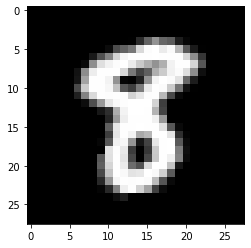

In [5]:
idx = random.randint(0, 100)
i = random.randint(0, 31)
random_image = train_generator.__getitem__(idx)[i].reshape(28,28)


plt.imshow(random_image, cmap = 'gray')

## TCAE (MASKS)

In [6]:
input_shape = (28,28,1)

latent_dim = config.latent_dim

# encoder 

def make_encoder(num_layers, num_filters_1, num_filters_2, num_filters_3):

    init_filters = num_filters_1

    encoder = keras.Sequential()
    encoder.add(keras.Input(shape = input_shape))
    encoder.add(layers.Conv2D(init_filters, (3,3), padding = 'same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Activation('relu'))
    encoder.add(layers.MaxPooling2D((2,2),padding = 'same'))

    for i in range(2):
        encoder.add(layers.Conv2D(num_filters_2, (3,3), activation = 'relu', padding = 'same'))
        encoder.add(layers.Activation('relu'))
        encoder.add(layers.MaxPooling2D((2,2),padding = 'same'))

    for i in range(num_layers-2):
        encoder.add(layers.Conv2D(num_filters_3, (3,3), activation = 'relu', padding = 'same'))
        encoder.add(layers.Activation('relu'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(latent_dim, activation = 'relu'))  

    return encoder

# decoder

def make_decoder(num_layers, num_filters_1, num_filters_2, num_filters_3):

    decoder = keras.Sequential()
    decoder.add(keras.Input(shape = (latent_dim,)))
    decoder.add(layers.Dense(7*7*32, activation = 'relu'))
    decoder.add(layers.Reshape(target_shape = (7,7,32)))

    for i in range(2):
        decoder.add(Conv2DTranspose(num_filters_1, (3,3), padding = 'same'))
        decoder.add(layers.Activation('relu'))
        decoder.add(UpSampling2D((2,2)))
    
    for i in range(num_layers-2):
        decoder.add(Conv2DTranspose(num_filters_2, (3,3), padding = 'same'))
        decoder.add(layers.Activation('relu'))
        
    decoder.add(Conv2DTranspose(num_filters_3, (3,3), padding = 'same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.Activation('relu'))

    decoder.add(Conv2DTranspose(1, (2,2), padding = 'same'))
    decoder.add(layers.Activation('sigmoid'))

    return decoder

# define number of layers
num_encoding_layers = config.num_encoding_layers
num_decoding_layers = config.num_decoding_layers

# make encoder
encoder = make_encoder(num_layers = num_encoding_layers, 
                       num_filters_1 = config.enc_num_filters_1, 
                       num_filters_2 = config.enc_num_filters_2, 
                       num_filters_3 = config.enc_num_filters_3)
encoder.summary()

'''# get preflattened shape 
pre_flatten_shape = K.int_shape(encoder.layers[-3].output)[1:]
print(pre_flatten_shape)

dense_out = 1
for elem in pre_flatten_shape:
    dense_out *= elem'''

# make decoder 
decoder = make_decoder(num_layers = num_decoding_layers, 
                       num_filters_1 = config.dec_num_filters_1, 
                       num_filters_2 = config.dec_num_filters_2, 
                       num_filters_3 = config.dec_num_filters_3)

decoder.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0

In [7]:
class TCAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.avg_loss_tracker = keras.metrics.Mean(name = 'avg_loss')
        self.avg_accuracy_tracker = keras.metrics.Mean(name = 'avg_accuracy')

    def compile(self, optimizer, loss_fn, accuracy_fn):
        super().compile()
        self.optimizer = optimizer 
        self.loss_fn = loss_fn
        self.accuracy_fn = accuracy_fn

    def train_step(self, data):

        avg_loss = 0
        avg_accuracy = 0

        for i in range(int(np.log2(latent_dim)+1)):

            with tf.GradientTape() as tape:
                # create mask
                ones_length = int(2**(np.log2(latent_dim)-i))
                zeros_length = int(latent_dim - ones_length)
                ones = tf.ones((ones_length)) 
                zeros = tf.zeros((zeros_length))
                mask = tf.concat([ones, zeros], axis = 0) 
                mask = tf.reshape(mask, (1,latent_dim))
     
                codes = self.encoder(data)
                masked_codes = tf.multiply(codes, mask)
                #print(codes.shape)
                #print(mask.shape)
                #print(masked_codes.shape)
                #masked_codes = tf.reshape(masked_codes, (tf.shape(codes)[0], latent_dim))
                
                reconstruction = self.decoder(masked_codes)

                loss = self.loss_fn(data, reconstruction)
                accuracy = self.accuracy_fn(data, reconstruction)
            
            avg_loss += loss
            avg_accuracy += accuracy
            # get gradients
            grads = tape.gradient(loss, self.trainable_weights)
            # apply gradients
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        avg_loss = avg_loss / int(np.log2(latent_dim)+1)
        avg_accuracy = avg_accuracy / int(np.log2(latent_dim+1))
            
        self.avg_loss_tracker.update_state(avg_loss)
        self.avg_accuracy_tracker.update_state(avg_accuracy)

        return {
            'avg_loss': self.avg_loss_tracker.result(),
            'avg_accuracy': self.avg_accuracy_tracker.result()
        }

    def custom_predict(self, data, n):

        # create mask
        ones_length = int(2**(n))
        zeros_length = int(latent_dim - ones_length)
        ones = tf.ones((ones_length)) 
        zeros = tf.zeros((zeros_length))
        mask = tf.concat([ones, zeros], axis = 0) 
        mask = tf.reshape(mask, (1,latent_dim))

        codes = self.encoder(data)
        masked_codes = tf.multiply(codes, mask)
        #masked_codes = tf.reshape(masked_codes, (1, latent_dim))
        
        reconstruction = self.decoder(masked_codes)

        return reconstruction

    def test_step(self, data):
        
        avg_loss = 0
        avg_accuracy = 0

        for i in range(int(np.log2(latent_dim)+1)):
            # create mask
            ones_length = int(2**(np.log2(latent_dim)-i))
            zeros_length = int(latent_dim - ones_length)
            ones = tf.ones((ones_length)) 
            zeros = tf.zeros((zeros_length))
            mask = tf.concat([ones, zeros], axis = 0) 
            mask = tf.reshape(mask, (1,latent_dim))

            # mask codes
            codes = self.encoder(data)
            masked_codes = tf.multiply(codes, mask)        
            reconstruction = self.decoder(masked_codes)

            loss = self.loss_fn(data, reconstruction)
            accuracy = self.accuracy_fn(data, reconstruction)
            
            avg_loss += loss
            avg_accuracy += accuracy
        
        avg_loss = avg_loss / int(np.log2(latent_dim)+1)
        avg_accuracy = avg_accuracy / int(np.log2(latent_dim+1))
            
        self.avg_loss_tracker.update_state(avg_loss)
        self.avg_accuracy_tracker.update_state(avg_accuracy)


        return {
            'avg_loss': self.avg_loss_tracker.result(),
            'avg_accuracy': self.avg_accuracy_tracker.result()
        }
    
    def call(self, data):
        codes = self.encoder(data)
        reconstruction = self.decoder(codes)

        return reconstruction


In [8]:
# test masking 

i = 2

ones_length = int(2**(i))
zeros_length = int(latent_dim - ones_length)
ones = tf.ones((ones_length)) 
zeros = tf.zeros((zeros_length))
mask = tf.concat([ones, zeros], axis = 0)
mask = tf.reshape(mask, (1, latent_dim,))

a = mask.numpy()
print(a)

[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
# initialize tcae

tcae = TCAE(encoder = encoder, decoder = decoder)
tcae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
             loss_fn = tf.keras.losses.binary_crossentropy, 
             accuracy_fn = tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None))

In [10]:
epochs = config.epochs

tcae.fit(train_generator, epochs = epochs, validation_data = test_dataset,
                   callbacks = [
                    WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("models", save_best_only = True, monitor = 'val_avg_loss')
                   ])
wandb.finish()
                    

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/3
938/938 [==============================] - ETA: 0s - avg_loss: 0.2144 - avg_accuracy: 0.9201

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


938/938 [==============================] - 1982s 2s/step - avg_loss: 0.2144 - avg_accuracy: 0.9201 - val_avg_loss: 0.1792 - val_avg_accuracy: 1.0096
Epoch 2/3
938/938 [==============================] - ETA: 0s - avg_loss: 0.1945 - avg_accuracy: 0.9218

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


938/938 [==============================] - 1704s 2s/step - avg_loss: 0.1945 - avg_accuracy: 0.9218 - val_avg_loss: 0.1704 - val_avg_accuracy: 1.0120
Epoch 3/3
938/938 [==============================] - ETA: 0s - avg_loss: 0.1897 - avg_accuracy: 0.9220

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


938/938 [==============================] - 1740s 2s/step - avg_loss: 0.1897 - avg_accuracy: 0.9220 - val_avg_loss: 0.1651 - val_avg_accuracy: 1.0139


batch/avg_accuracy,▁▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆█▇▇▆▆▆▆▆▆▆▆▆▆
batch/avg_loss,█▆▅▄▄▄▃▃▃▃▃▃▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/avg_accuracy,▁██
epoch/avg_loss,█▂▁
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/val_avg_accuracy,▁▅█
epoch/val_avg_loss,█▄▁
batch/avg_accuracy,0.92196


In [ ]:
"""save weights"""
#tcae.save_weights('/Users/andrewgoh/Desktop/NDC/weights/tcae_weights', overwrite=True, save_format=None, options=None)

In [ ]:
"""load weights"""
"""tcae = TCAE(encoder = encoder, decoder = decoder)
tcae.load_weights('/Users/andrewgoh/Desktop/NDC/weights/tcae_weights', by_name=False, skip_mismatch=False, options=None)

# set optimizer and compile 
tcae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss_fn = tf.keras.losses.BinaryCrossentropy())"""

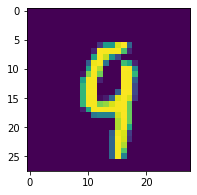

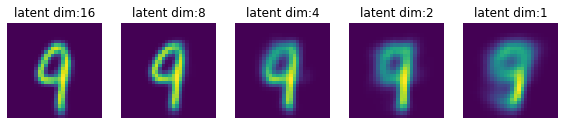

In [34]:
index = random.randint(0, np.shape(all_digits)[0]-1)
img = all_digits[index,:,:,0]

plt.figure(figsize = (3,3))
plt.imshow(img)

img = img.reshape(1, 28, 28, 1)

plt.figure(figsize = (16,5))
for i in range(int(np.log2(latent_dim))+1):
    ax = plt.subplot(2, 8, i + 1)
    reconstruction = tcae.custom_predict([img], np.log2(latent_dim)-i)
    reconstruction = reconstruction.numpy().reshape(28,28)
    plt.title('latent dim:{}'.format(int(2**(np.log2(latent_dim)-i))))
    plt.imshow(reconstruction)
    plt.axis('off')


